In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [13]:
import os

os.environ['KAGGLE_USERNAME'] = 'ardhisparahitaa'
os.environ['KAGGLE_KEY'] = 'KGAT_1f46ada91cee62587da6c096c73e234e'


In [14]:
!pip install kaggle


In [15]:
!kaggle datasets list


ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                           Chocolate Sales                                         468320  2026-01-04 14:23:35.490000           8991        146  1.0              
vishardmehta/delhi-pollution-aqi-dataset                      Delhi Pollution AQI dataset                            5299345  2026-01-26 14:14:04.553000            877         27  1.0              
ayeshaimran1619/customer-spending-patterns                    Customer Spending Patterns                               72157  2026-01-24 14:56:48.767000            730         23  1.0              
aliiihussa

In [16]:
!kaggle datasets download -d lakshmi25npathi/online-retail-dataset


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset
License(s): other
  0% 0.00/43.3M [00:00<?, ?B/s]
100% 43.3M/43.3M [00:00<00:00, 1.13GB/s]


In [17]:
!unzip -o online-retail-dataset.zip


Archive:  online-retail-dataset.zip
  inflating: online_retail_II.xlsx   


In [18]:
!ls


online-retail-dataset.zip  online_retail_II.xlsx  sample_data


In [22]:
df = pd.read_excel("online_retail_II.xlsx")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


(525461, 8)

In [25]:
# Hapus data tanpa CustomerID
df = df.dropna(subset=['Customer ID'])

# Hapus transaksi retur
df = df[df['Quantity'] > 0]

# Konversi tanggal
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.shape


(407695, 8)

In [29]:
reference_date = df['InvoiceDate'].max()

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'count',
    'Price': lambda x: np.sum(x * df.loc[x.index, 'Quantity'])
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,164,33,372.86
12347.0,2,71,1323.32
12348.0,73,20,222.16
12349.0,42,102,2671.14
12351.0,10,21,300.93


In [30]:
rfm.describe()


,Recency,Frequency,Monetary
count,4314.000000,4314.000000,4314.000000
mean,90.269124,94.505100,2047.288659
std,96.943482,202.020116,8912.523243
min,0.000000,1.000000,0.000000
25%,17.000000,18.000000,307.950000
50%,52.000000,44.000000,705.550000
75%,135.000000,102.000000,1722.802500
max,373.000000,5570.000000,349164.350000


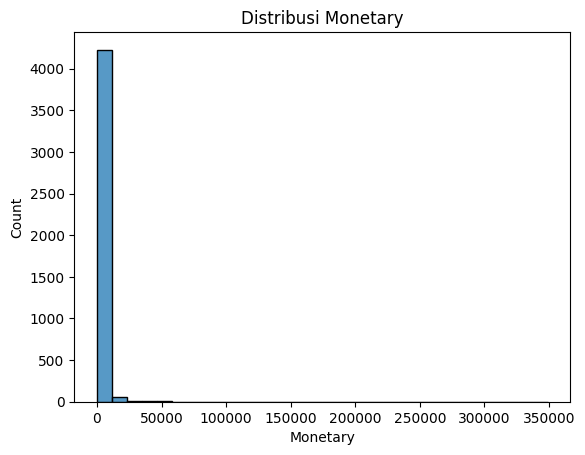

In [31]:
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Distribusi Monetary")
plt.show()


In [32]:
features = ['Recency', 'Frequency', 'Monetary']

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    columns=features,
    index=rfm.index
)


In [33]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,164,33,372.86,2
12347.0,2,71,1323.32,0
12348.0,73,20,222.16,0
12349.0,42,102,2671.14,0
12351.0,10,21,300.93,0


In [34]:
silhouette_score(rfm_scaled, rfm['Cluster'])


np.float64(0.6245743985588414)

In [35]:
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,31.296518,123.144917,2712.913299
1,281.682300,26.476551,587.990415
2,141.053086,49.497531,901.887778


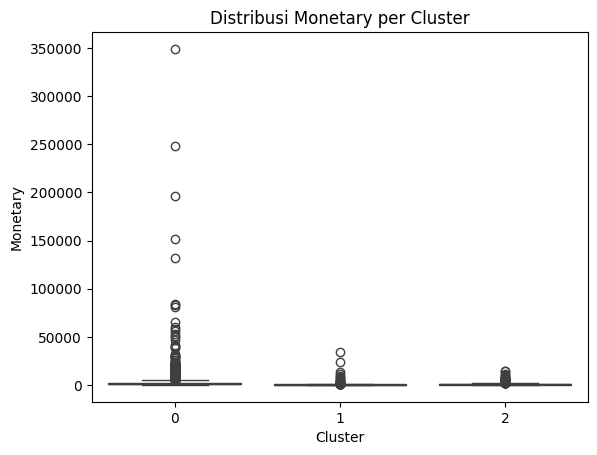

In [36]:
sns.boxplot(x='Cluster', y='Monetary', data=rfm.reset_index())
plt.title("Distribusi Monetary per Cluster")
plt.show()


In [37]:
rfm.to_csv("hasil_segmentasi_pelanggan.csv")
